# Ingestion

Apr 12, 2024


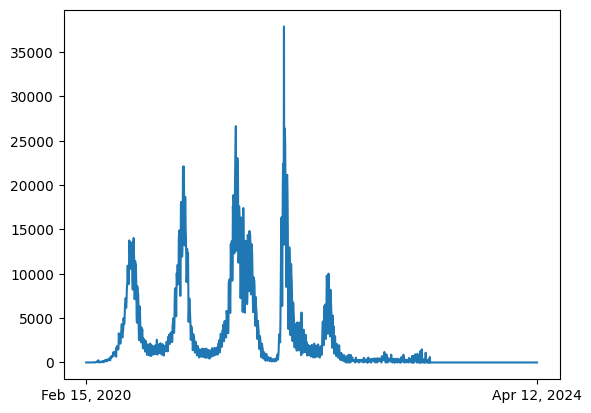

In [147]:
from bs4 import BeautifulSoup
import requests
import re
import json
import matplotlib.pyplot as plt
import pandas as pd

soup                = BeautifulSoup(requests.get("https://www.worldometers.info/coronavirus/country/south-africa/").content, "html.parser")
graph_cases_daily   = soup.find("script", string=lambda t: 'Highcharts' and 'graph-cases-daily' in t if t else False).get_text()
# Extraction of dates data
dates_regex = re.compile(r"xAxis:\s*{\s*categories:\s*(\[[^\]]+\])")
dates_matched = dates_regex.search(graph_cases_daily)
dates = json.loads(dates_matched.group(1)) if dates_matched else []

# Extraction of daily cases
daily_cases_pattern = re.compile(r"series:\s*\[\s*{[^}]*name:\s*'Daily Cases'[^}]*data:\s*(\[[^\]]+\])")
daily_cases_match = daily_cases_pattern.search(graph_cases_daily)

# Cleaning data

daily_cases_data = json.loads(daily_cases_match.group(1)) if daily_cases_match else []
daily_cases_data = [0 if case == None else case for case in daily_cases_data]

# end_date = 'April 13, 2024'
print(dates[-1])

# Create a DataFrame from the two arrays
data = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'cases': daily_cases_data
})

# Set the 'date' column as the index
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

plt.plot(dates, daily_cases_data)
plt.xticks([0, len(dates) - 1], [dates[0], dates[-1]])
plt.show()

# Modelling

In [136]:
# Testing for stationarity
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['cases'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.881124
p-value: 0.002178


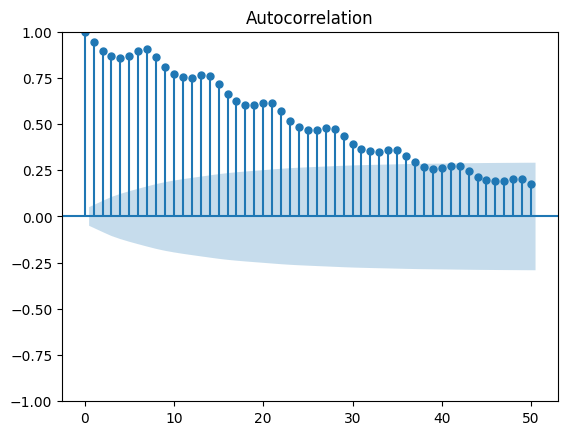

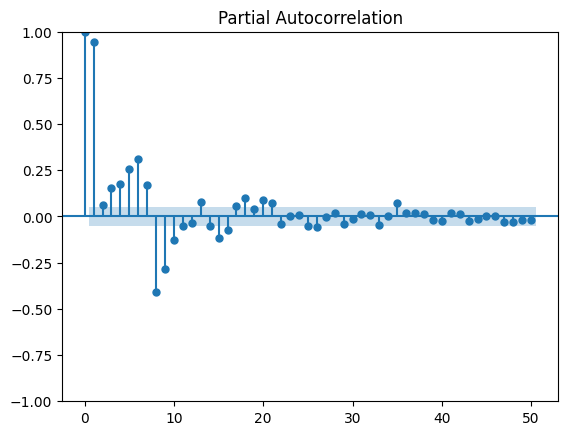

In [137]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Test for the differencing term
plot_acf(data['cases'], lags=50) 
plot_pacf(data['cases'], lags=50)
plt.show()

/Users/jackmontgomery/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


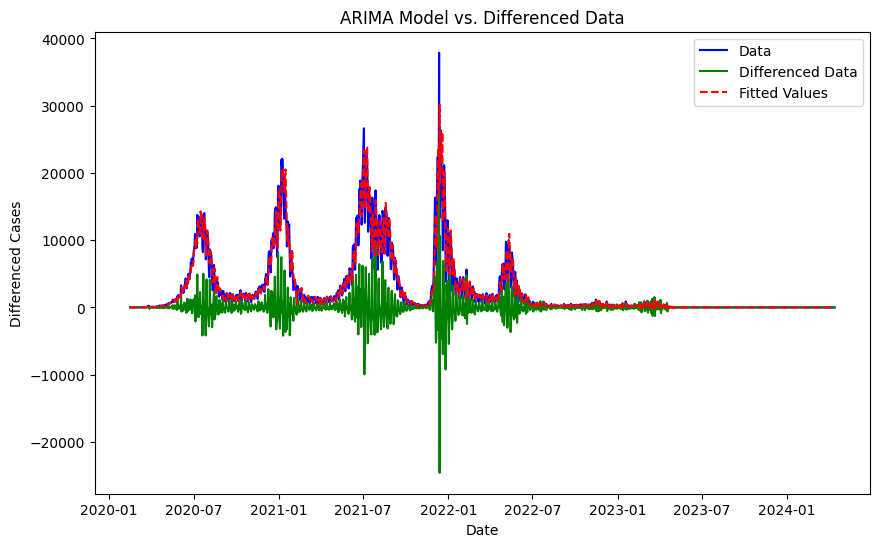

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(data['cases'], order=(1, 1, 7))
model_fit = model.fit()

# Get the fitted values
fitted_values = model_fit.fittedvalues

# Since the model is differenced, you need to plot the differenced data
differenced_data = data['cases'].diff().dropna()

# Plot the differenced data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(data['cases'], label='Data', color='blue')
plt.plot(differenced_data, label='Differenced Data', color='green')
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')
plt.title('ARIMA Model vs. Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Cases')
plt.legend()
plt.show()

/Users/jackmontgomery/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


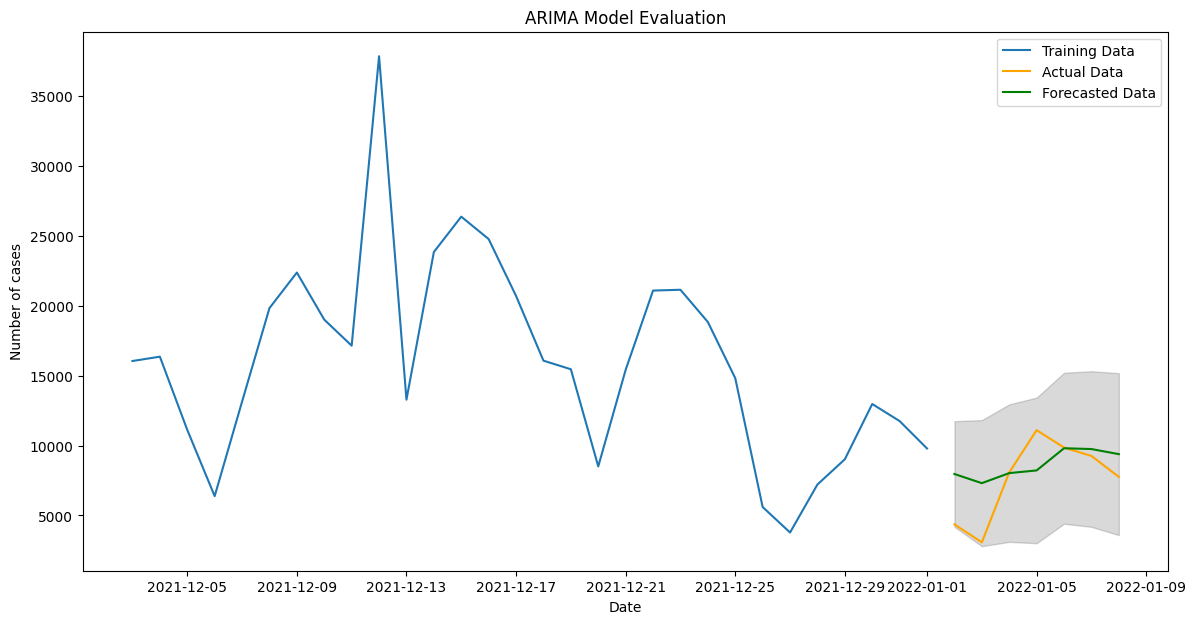

RMSE: 2454.5466280032983


In [182]:
from sklearn.metrics import mean_squared_error

# Split the data into train and test

specific_date = pd.Timestamp('2022-01-01')
index_location = data.index.get_loc(specific_date)

train_size = int(index_location + 1)
train, test = data[0:train_size], data[train_size:train_size+7]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['cases'], order=(1, 1, 7))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['cases'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['cases'][-30:], label='Training Data')
plt.plot(test['cases'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of cases')
plt.legend()
plt.show()

print('RMSE:', rmse)